# **Connect google drive to the google colab**

In [1]:
from google.colab import drive
drive.mount('/content/google_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/google_drive


In [0]:
file_path = "google_drive/My Drive/Colab Notebooks"

# **Install dependencies for rendering video in Google Colab**

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [0]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [5]:
!apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils
0 upgraded, 2 newly installed, 0 to remove and 32 not upgraded.
Need to get 209 kB of archives.
After this operation, 711 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Fetched 209 kB in 2s (130 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 146829 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
Selecting previously unselected package x11-utils.
Preparing to unpack .../x11-utils_7.7+3build1_amd64.de

In [6]:
# RUN THIS IF YOU GET ERROR BASE NOT FOUND
!pip install pyglet --upgrade

     |████████████████████████████████| 1.1MB 2.6MB/s 
ERROR: gym 0.17.2 has requirement pyglet<=1.5.0,>=1.4.0, but you'll have pyglet 1.5.5 which is incompatible.
  Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0


In [7]:
import gym
from gym.wrappers import Monitor
import os
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import glob
import io
import base64
from IPython.display import HTML,clear_output,Image
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# **Environment**

In [0]:
class Environment(object):
    def __init__(self,name, ACTIONS):
        self.env = gym.make(name)
        self.ACTIONS = ACTIONS
    def resetEnv(self,NUM_OF_FRAMES):
        self.env.reset()
        frames = []
        reward = 0
        done = False
        for i in range(NUM_OF_FRAMES):
            obs, r, d, info = self.env.step(self.ACTIONS["NOOP"])
            reward += r
            done = done | d
            frame = preprocessFrame(obs, RESOLUTION)
            frames.append(frame)
        return frames, reward, done
    def step(self,action):
        observation, reward, done, info = self.env.step(action)
        return observation, reward, done, info
    def render(self):
        self.env.render()
        return
    def show_video(self):
        mp4list = glob.glob('video/*.mp4')
        mp4list = sorted(mp4list)
        if len(mp4list) > 0:
            mp4 = mp4list[-1]
            print(mp4)
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
        else: 
            print("Could not find video")
        return
    def wrap_env(self):
        self.env = Monitor(self.env, os.path.join(os.getcwd(),'video'), force=True)
        return 

# **Replay Buffer**

In [0]:
from numpy import random
import matplotlib.pyplot as plt
import numpy as np

class ReplayBuffer(object):
    def __init__(self,BUFFER_SIZE, RESOLUTION, NUM_OF_FRAMES):
        self.BUFFER_SIZE = BUFFER_SIZE
        self.RESOLUTION = RESOLUTION
        self.NUM_OF_FRAMES = NUM_OF_FRAMES
        self.buffer = []
    def add(self,s ,a ,r ,s_next, done):
        if (len(self.buffer) == self.BUFFER_SIZE): # if the buffer is full
            self.buffer.pop(0) # remove first element
        self.buffer.append((s,a,r,s_next,done))
    def size(self):
        return len(self.buffer)
    def sample(self, batch_size):
        if (len(self.buffer) >= batch_size):
            indicies = random.choice(self.size(), size=batch_size)
            samples=[]
            for ind in indicies:
                sample = self.buffer[ind]
                samples.append((unpackState(sample[0], self.RESOLUTION, self.NUM_OF_FRAMES),
                                sample[1],
                                sample[2],
                                unpackState(sample[3], self.RESOLUTION, self.NUM_OF_FRAMES),
                                sample[4]
                                ))
        else:
            raise ValueError("Replay buffer needs more data")
        return samples

# **Double Deep Q network**

In [10]:
from keras.layers import Input, Conv2D, Activation, Flatten, Dense
from keras.optimizers import Adam, RMSprop
from keras.models import load_model, Model
from keras import backend as K
import os 
import numpy as np
import matplotlib.pyplot as plt

class DQN(object):
    def __init__(self, RESOLUTION, NUM_OF_FRAMES, NUM_OF_ACTIONS, optimizer):
        self.network = self._createNetwork(RESOLUTION, NUM_OF_FRAMES, NUM_OF_ACTIONS, OPTIMIZER)
        self.target_network = self._createNetwork(RESOLUTION, NUM_OF_FRAMES, NUM_OF_ACTIONS, OPTIMIZER)
        self.target_network.set_weights(self.network.get_weights())
    def _createNetwork(self, RESOLUTION, NUM_OF_FRAMES, NUM_OF_ACTIONS, OPTIMIZER):
        inputs = Input(shape=(RESOLUTION, RESOLUTION, NUM_OF_FRAMES))
        X = Conv2D(filters=32, kernel_size=(8,8), strides=(4,4))(inputs)
        X = Activation('relu')(X)
        X = Conv2D(filters=64, kernel_size=(4,4), strides=(2,2))(X)
        X = Activation('relu')(X)
        X = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1))(X)
        X = Activation('relu')(X)
        X = Flatten()(X) 
        X = Dense(units=512)(X)
        X = Activation('relu')(X)
        outputs = Dense(units=NUM_OF_ACTIONS)(X)
    
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=OPTIMIZER, loss=self.huber_loss)
        return model
    def huber_loss(self,a,b,in_keras=True):
        error = a - b
        quadratic_term = error*error / 2
        linear_term = abs(error) - 1/2
        use_linear_term = (abs(error) > 1.0)
        if in_keras:
            # Keras won't let us multiply floats by booleans, so we explicitly cast the booleans to floats
            use_linear_term = K.cast(use_linear_term, 'float32')
        return use_linear_term * linear_term + (1-use_linear_term) * quadratic_term
    def train_network(self, batch, BATCH_SIZE, GAMMA, NUM_OF_ACTIONS):
        s_batch, a_batch, r_batch, s_new_batch, d_batch = map(np.array, zip(*batch))
        target_batch = np.zeros((BATCH_SIZE, NUM_OF_ACTIONS))
        for j in range(BATCH_SIZE):
            target_batch[j,:] = self.network.predict(np.expand_dims(s_batch[j],axis=0), batch_size=1) # weights will be updated only for action a_batch[j]
            Q_target_next = self.target_network.predict(np.expand_dims(s_new_batch[j],axis=0), batch_size=1)
            if (d_batch[j] == True):
                target_batch[j, int(a_batch[j])] = r_batch[j]
            else: 
                target_batch[j, int(a_batch[j])] = r_batch[j] + GAMMA*np.max(Q_target_next)
        loss = self.network.train_on_batch(s_batch, target_batch)
        return loss
    def update_target_network(self):
        self.target_network.set_weights(self.network.get_weights())
        return 
    def save_network(self,file_path):
        path = os.path.join(file_path,"trained_model")
        os.makedirs(path, exist_ok=True)
        save_path = os.path.join(path,"model.h5")
        self.network.save(save_path)
        print("The network is saved to {}".format(save_path))
    def load_network(self,file_path):
        path = os.path.join(file_path,"trained_model")
        load_path = os.path.join(path,"model.h5")
        self.network = load_model(load_path,custom_objects={'huber_loss': self.huber_loss})
        self.target_network = load_model(load_path,custom_objects={'huber_loss': self.huber_loss})
        print("The network is loaded from {}".format(load_path))

Using TensorFlow backend.


# **Additional functions**

In [0]:
import cv2
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import pickle
import os
import sys

def preprocessFrame(frame, RESOLUTION): 
    # convert to gray and resize
    frame = cv2.cvtColor(cv2.resize(frame, (RESOLUTION, RESOLUTION)), cv2.COLOR_BGR2GRAY)
    # make it binary
    _, frame = cv2.threshold(frame,1,255,cv2.THRESH_BINARY)
    return frame
def packState(state):
    return np.packbits(state)
def unpackState(state, RESOLUTION, NUM_OF_FRAMES):
    return np.unpackbits(state).reshape(RESOLUTION,RESOLUTION,NUM_OF_FRAMES)
def stackFrames(frames):
    return np.stack(frames, axis=-1).astype("uint8")
def average(data, frequency, start_avg_point):
    average_data = []
    if (len(data) > start_avg_point):
        round_num = -(len(str(frequency))-1)
        for i in range(0,round(len(data),round_num)-frequency,frequency):
            avg_data=mean(data[i:i+frequency])
            average_data.append(avg_data)
    return average_data
def save_to_disk(txt_path, values):
    if os.path.isfile(txt_path):
        os.remove(txt_path)
    with open(txt_path, "wb") as fp:   
        pickle.dump(values, fp)
    return
def load_from_disk(txt_path):
    with open(txt_path, "rb") as f:
        values =  pickle.load(f)
    return values
def plot_variable(values, xlabel, ylabel, title, save_path):
    fig = plt.figure(figsize=(12, 6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(values, figure=fig)
    plt.savefig(save_path)
    plt.show(block=False)
    return
def report(losses, episode_rewards, Q_values, file_path, replay_buffer, epsilon, eval_rewards, eval_Q_values):
    plots_dir = os.path.join(file_path,'plots')
    os.makedirs(plots_dir, exist_ok=True)
    # episode rewards
    save_path = os.path.join(plots_dir,"reward.png")
    plot_variable(episode_rewards, 'episodes', 'reward', 'Reward through episodes', save_path)
    # average reward
    average_rewards = average(episode_rewards, 100,200)
    if (len(average_rewards) != 0):
        save_path = os.path.join(plots_dir,"rewardAveraged.png")
        plot_variable(average_rewards, 'episodes', 'reward', 'Reward averaged over last 100 episodes', save_path)
    # average loss
    average_losses = average(losses, 1000, 20000)
    if (len(average_losses) != 0):
        save_path = os.path.join(plots_dir,"lossAveraged.png")
        plot_variable(average_losses, 'num of weight updates*1000', 'loss', 'Loss averaged over 1000 weight updates', save_path)       
    # average Q values
    average_Q = average(Q_values, 1000, 20000)
    if (len(average_Q) != 0):
        save_path = os.path.join(plots_dir,"QvaluesAveraged.png")
        plot_variable(average_Q, 'num of weight updates*1000', 'Q value', 'Q values averaged over 1000 weight updates', save_path)
    # eval rewards
    save_path = os.path.join(plots_dir,"evalRewards.png")
    plot_variable(eval_rewards, 'epochs', 'reward', 'Reward averaged over 30 episodes', save_path)
    save_path = os.path.join(plots_dir,"evalQvalues.png")
    plot_variable(eval_Q_values, 'epochs', 'Q value', 'Q values averaged over 30 episodes', save_path)
    # save variables to file
    txt_path = os.path.join(file_path,"loss.txt")
    save_to_disk(txt_path,losses)
    print("Loss is saved to {}".format(txt_path))
    txt_path = os.path.join(file_path,"Qvalues.txt")
    save_to_disk(txt_path,Q_values)
    print("Q values are saved to {}".format(txt_path))    
    txt_path = os.path.join(file_path,"rewards.txt")
    save_to_disk(txt_path,episode_rewards)
    print("Rewards are saved to {}".format(txt_path))
    txt_path = os.path.join(file_path,"replayBuffer.txt")
    save_to_disk(txt_path,replay_buffer)
    print("Replay buffer is saved to {}".format(txt_path))
    txt_path = os.path.join(file_path,"epsilon.txt")
    save_to_disk(txt_path,epsilon)
    print("Epsilon is saved to {}".format(txt_path))
    txt_path = os.path.join(file_path,"evalRewards.txt")
    save_to_disk(txt_path,eval_rewards)
    print("Eval rewards are saved to {}".format(txt_path))
    txt_path = os.path.join(file_path,"evalQvalues.txt")
    save_to_disk(txt_path,eval_Q_values)
    print("Eval Q values are saved to {}".format(txt_path))
    return
def load_saved_data(file_path):
    # load saved variables
    txt_path = os.path.join(file_path,"epsilon.txt")
    epsilon = load_from_disk(txt_path)
    print("Epsilon is loaded from {}".format(txt_path))
    txt_path = os.path.join(file_path,"replayBuffer.txt")
    replay_buffer = load_from_disk(txt_path)
    print("Replay Buffer is loaded from {}".format(txt_path))
    txt_path = os.path.join(file_path,"loss.txt")
    losses = load_from_disk(txt_path)
    losses = list(losses)
    print("Loss is loaded from {}".format(txt_path))
    txt_path = os.path.join(file_path,"Qvalues.txt")
    Q_values = load_from_disk(txt_path)
    print("Q values are loaded from {}".format(txt_path))
    txt_path = os.path.join(file_path,"rewards.txt")
    episode_rewards = load_from_disk(txt_path)
    print("Rewards are loaded from {}".format(txt_path))
    txt_path = os.path.join(file_path,"evalRewards.txt")
    eval_rewards = load_from_disk(txt_path)
    print("Eval rewards are loaded from {}".format(txt_path))
    txt_path = os.path.join(file_path,"evalQvalues.txt")
    eval_Q_values = load_from_disk(txt_path)
    print("Eval Q values are loaded from {}".format(txt_path))
    num_of_weight_updates = len(losses)
    return epsilon, replay_buffer, losses, Q_values, episode_rewards, num_of_weight_updates, eval_rewards, eval_Q_values

# **Hyperparameters**


In [0]:
ACTIONS = {"NOOP":0,"FIRE":1,"RIGHT":2,"LEFT":3,"RIGHTFIRE":4,"LEFTFIRE":5}
NUM_OF_FRAMES = 4 # number of frames that make 1 state
EPISODES = 10000 # number of episodes
BUFFER_SIZE = 300000 # size of the replay buffer(can not put bigger size, RAM)
MIN_OBSERVATIONS = 30000
RESOLUTION = 84 # resolution of frames
BATCH_SIZE = 32
EPSILON_START = 1 # starting value for the exploration probability
EPSILON_END = 0.1 
FINAL_EXPLORATION_STATE = 500000 # final frame for which epsilon is decayed
GAMMA = 0.99 # discount factor
TARGET_NETWORK_UPDATE_FREQ = 40000 
REPORT_EPISODE_FREQ = 100
TRAINING_FREQUENCY = 4
OPTIMIZER = RMSprop(lr=0.00025,rho=0.95,epsilon=0.01)

# **Agent**

In [0]:
from statistics import mean

class Agent(object):

    def EGreedyPolicy(self,Q, state, epsilon, NUM_OF_ACTIONS):
        Q_values = Q.network.predict(np.expand_dims(state,axis=0), batch_size=1)
        if (np.random.random() < epsilon): # exploration
            action = np.random.randint(0, NUM_OF_ACTIONS)
            is_greedy_action = False
        else:  # exploitation
            action = np.argmax(Q_values)
            is_greedy_action = True
        return action, Q_values[0,action], is_greedy_action
    def decayEpsilon(self, epsilon, start, end, states_num):
        d_epsilon = (start-end)/states_num
        epsilon = epsilon - d_epsilon
        return epsilon
    def getCustomReward(self, reward, info, LIFE_CHECKPOINT):
        if reward > 0:
            reward = 1
        if 'ale.lives' in info is not None:
            if info['ale.lives'] != LIFE_CHECKPOINT: # if you lost a life
                if LIFE_CHECKPOINT == 0: # when starting a new episode
                    LIFE_CHECKPOINT = 3
                    reward = 0
                else: # get punishment
                    LIFE_CHECKPOINT = info['ale.lives']
                    reward = -1
        else:
            print("Lives is None")
            if LIFE_CHECKPOINT != 0:
                LIFE_CHECKPOINT = 0
                reward = -1
            else:
                reward = 0
        return reward, LIFE_CHECKPOINT
    def train(self, Q, space_invaders, file_path, continue_training, EPISODE=0):
        if continue_training:
            epsilon, replay_buffer, losses, Q_values, episode_rewards, num_of_weight_updates, eval_rewards, eval_Q_values = load_saved_data(file_path)
        else:
            epsilon = EPSILON_START
            num_of_weight_updates = 0
            episode_rewards = []
            losses = []
            Q_values = [] 
            eval_rewards = []
            eval_Q_values = []
            replay_buffer = ReplayBuffer(BUFFER_SIZE, RESOLUTION, NUM_OF_FRAMES)
        
        frame_count = 0
        LIFE_CHECKPOINT = 3
        for episode in range(EPISODE,EPISODES):
            # reset the environment and init variables
            frames, _, _ = space_invaders.resetEnv(NUM_OF_FRAMES)
            state = stackFrames(frames)
            done = False
            episode_reward = 0
            episode_reward_clipped = 0
            frames_buffer = frames # contains preprocessed frames (not stacked)
            while not done:
                if (episode % REPORT_EPISODE_FREQ == 0):
                    space_invaders.render()
                # select an action from behaviour policy
                action, Q_value, is_greedy_action = self.EGreedyPolicy(Q, state, epsilon, len(ACTIONS))
                # perform action in the environment
                observation, reward, done, info = space_invaders.step(action)
                episode_reward += reward # update episode reward
                reward, LIFE_CHECKPOINT = self.getCustomReward(reward, info, LIFE_CHECKPOINT)
                episode_reward_clipped += reward
                frame = preprocessFrame(observation, RESOLUTION)
                # pop first frame from the buffer, and add new at the end (s1=[f1,f2,f3,f4], s2=[f2,f3,f4,f5])
                frames_buffer.append(frame) 
                frames_buffer.pop(0)
                new_state = stackFrames(frames_buffer)
                # add (s,a,r,s') tuple to the replay buffer
                replay_buffer.add(packState(state), action, reward, packState(new_state), done)
                
                state = new_state # new state becomes current state
                frame_count += 1
                if (replay_buffer.size() > MIN_OBSERVATIONS): # if there is enough data in replay buffer
                    Q_values.append(Q_value)
                    if (frame_count % TRAINING_FREQUENCY == 0):
                        batch = replay_buffer.sample(BATCH_SIZE)
                        loss = Q.train_network(batch, BATCH_SIZE, GAMMA, len(ACTIONS))
                        losses.append(loss)
                        num_of_weight_updates += 1
                    if (epsilon > EPSILON_END):
                        epsilon = self.decayEpsilon(epsilon, EPSILON_START, EPSILON_END, FINAL_EXPLORATION_STATE)
                if (num_of_weight_updates % TARGET_NETWORK_UPDATE_FREQ == 0) and (num_of_weight_updates != 0): # update weights of target network
                    Q.update_target_network() 
                    print("Target_network is updated!")
            episode_rewards.append(episode_reward)

            print("EPISODE {}".format(episode))
            print("reward: {}".format(episode_reward))
            print("Clipped reward: {}".format(episode_reward_clipped))
            print("epsilon: {}".format(epsilon))
            print("buffer size: {}".format(replay_buffer.size()))
            if (episode % REPORT_EPISODE_FREQ == 0):
                space_invaders.show_video()
                Q.save_network(file_path)
                _, _, eval_reward, eval_Q_value = self.play_game(0.05, Q, space_invaders, 30)
                eval_rewards.append(eval_reward)
                eval_Q_values.append(eval_Q_value)
                report(losses, episode_rewards, Q_values, file_path, replay_buffer, epsilon, eval_rewards, eval_Q_values)
    def play_game(self,epsilon, Q, space_invaders, episodes, load_pretrained=False, render=False):
        print("Playing the game!")
        if load_pretrained:
            Q.load_network(file_path)
        episode_rewards = []
        Q_values = []
        for episode in range(episodes):
            frames, reward, _ = space_invaders.resetEnv(NUM_OF_FRAMES)
            state = stackFrames(frames)
            done = False
            episode_reward = 0
            frames_buffer = frames
            while not done:
                # select an action from behaviour policy
                action, Q_value, is_greedy_action = self.EGreedyPolicy(Q, state, epsilon, len(ACTIONS))
                if render:
                    space_invaders.render()
                # perform action in the environment
                observation, reward, done, info = space_invaders.step(action)
                # pop first frame from the buffer, and add new at the end (s1=[f1,f2,f3,f4], s2=[f2,f3,f4,f5])
                frame = preprocessFrame(observation, RESOLUTION)
                frames_buffer.append(frame) 
                frames_buffer.pop(0)
                new_state = stackFrames(frames_buffer)
                state = new_state # new state becomes current state

                episode_reward += reward # update episode reward
                Q_values.append(Q_value)
            print("EPSIODE {}".format(episode))
            print("episode reward: {}".format(episode_reward))
            episode_rewards.append(episode_reward)
        return episode_rewards, Q_values, mean(episode_rewards), mean(Q_values)



# **Start training**

In [0]:
import gym
import numpy as np
import sys
%matplotlib inline
import matplotlib.pyplot as plt

space_invaders = Environment('SpaceInvaders-v0',ACTIONS)
space_invaders.wrap_env()
Q = DQN(RESOLUTION, NUM_OF_FRAMES, len(ACTIONS), OPTIMIZER)

agent = Agent()
agent.train(Q, space_invaders, file_path, continue_training=False)

Output hidden; open in https://colab.research.google.com to view.

# **Continue training**

The network is loaded from google_drive/My Drive/Colab Notebooks/trained_model/model.h5
Epsilon is loaded from google_drive/My Drive/Colab Notebooks/epsilon.txt
Replay Buffer is loaded from google_drive/My Drive/Colab Notebooks/replayBuffer.txt
Loss is loaded from google_drive/My Drive/Colab Notebooks/loss.txt
Q values are loaded from google_drive/My Drive/Colab Notebooks/Qvalues.txt
Rewards are loaded from google_drive/My Drive/Colab Notebooks/rewards.txt
Eval rewards are loaded from google_drive/My Drive/Colab Notebooks/evalRewards.txt
Eval Q values are loaded from google_drive/My Drive/Colab Notebooks/evalQvalues.txt
EPISODE 500
reward: 45.0
Clipped reward: 2.0
epsilon: 0.4130037999858035
buffer size: 300000
video/openaigym.video.0.118.video000000.mp4


The network is saved to google_drive/My Drive/Colab Notebooks/trained_model/model.h5
Playing the game!
EPSIODE 0
episode reward: 55.0
EPSIODE 1
episode reward: 515.0
EPSIODE 2
episode reward: 30.0
EPSIODE 3
episode reward: 225.0
EPSIODE 4
episode reward: 55.0
EPSIODE 5
episode reward: 670.0
EPSIODE 6
episode reward: 130.0
EPSIODE 7
episode reward: 390.0
EPSIODE 8
episode reward: 520.0
EPSIODE 9
episode reward: 85.0
EPSIODE 10
episode reward: 145.0
EPSIODE 11
episode reward: 180.0
EPSIODE 12
episode reward: 35.0
EPSIODE 13
episode reward: 110.0
EPSIODE 14
episode reward: 60.0
EPSIODE 15
episode reward: 120.0
EPSIODE 16
episode reward: 80.0
EPSIODE 17
episode reward: 35.0
EPSIODE 18
episode reward: 125.0
EPSIODE 19
episode reward: 390.0
EPSIODE 20
episode reward: 335.0
EPSIODE 21
episode reward: 155.0
EPSIODE 22
episode reward: 180.0
EPSIODE 23
episode reward: 190.0
EPSIODE 24
episode reward: 170.0
EPSIODE 25
episode reward: 230.0
EPSIODE 26
episode reward: 215.0
EPSIODE 27
episode rewar

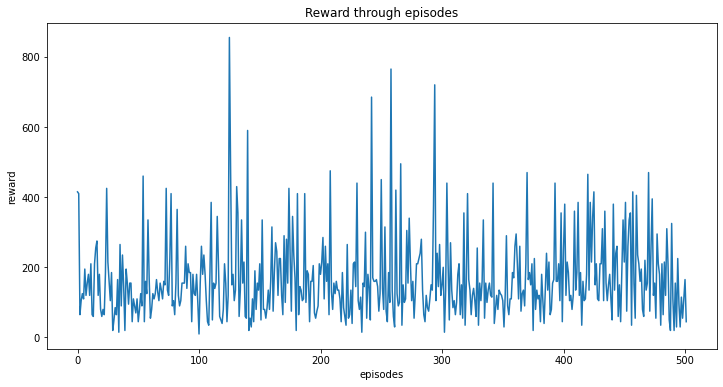

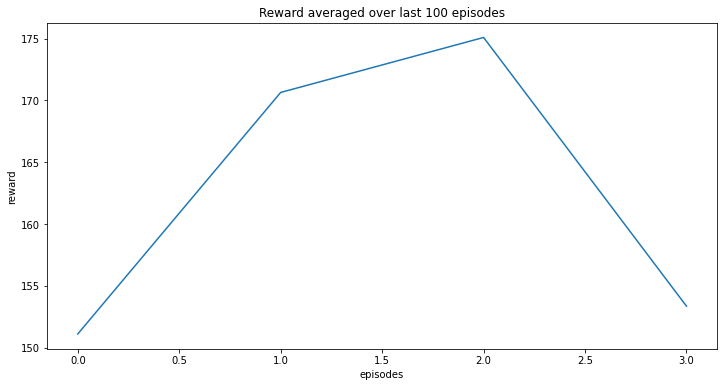

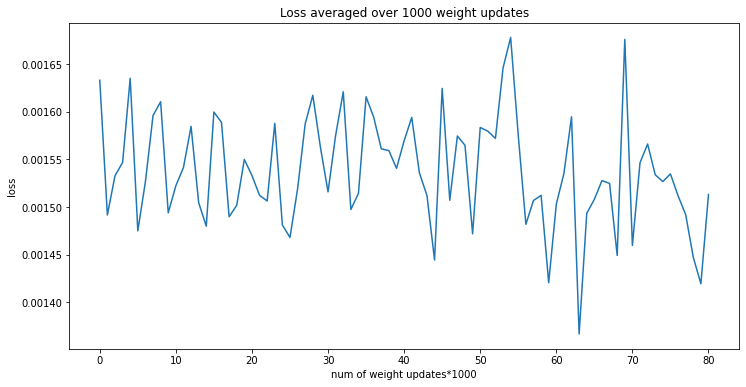

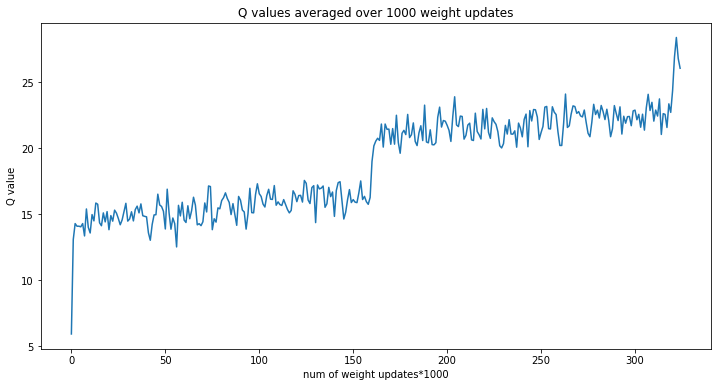

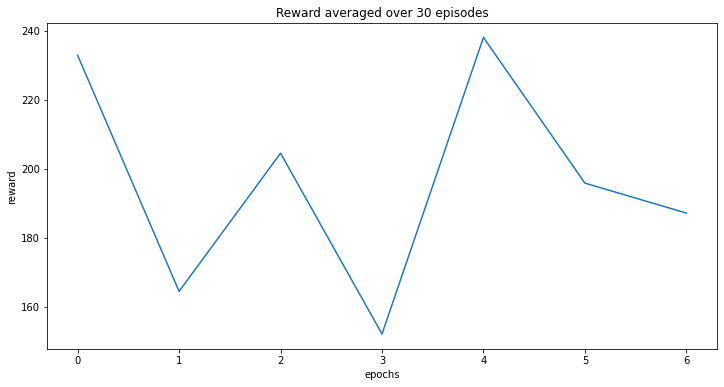

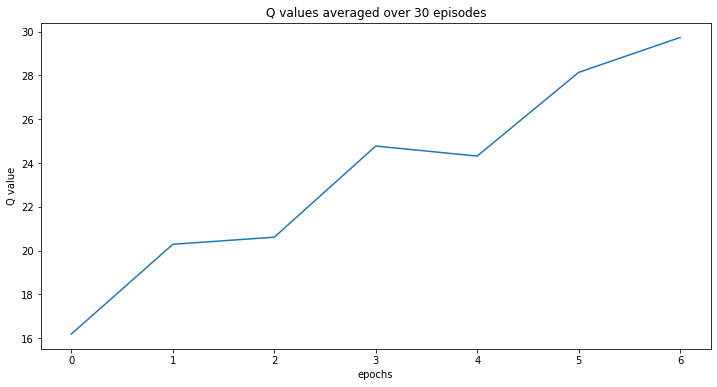

Loss is saved to google_drive/My Drive/Colab Notebooks/loss.txt
Q values are saved to google_drive/My Drive/Colab Notebooks/Qvalues.txt
Rewards are saved to google_drive/My Drive/Colab Notebooks/rewards.txt
Replay buffer is saved to google_drive/My Drive/Colab Notebooks/replayBuffer.txt
Epsilon is saved to google_drive/My Drive/Colab Notebooks/epsilon.txt
Eval rewards are saved to google_drive/My Drive/Colab Notebooks/evalRewards.txt
Eval Q values are saved to google_drive/My Drive/Colab Notebooks/evalQvalues.txt
EPISODE 501
reward: 5.0
Clipped reward: -2.0
epsilon: 0.412287399985805
buffer size: 300000
EPISODE 502
reward: 50.0
Clipped reward: 3.0
epsilon: 0.4116213999858064
buffer size: 300000
EPISODE 503
reward: 50.0
Clipped reward: 1.0
epsilon: 0.4109805999858077
buffer size: 300000
EPISODE 504
reward: 35.0
Clipped reward: 1.0
epsilon: 0.4102785999858092
buffer size: 300000
EPISODE 505
reward: 155.0
Clipped reward: 7.0
epsilon: 0.4090815999858117
buffer size: 300000
EPISODE 506
rewa

The network is saved to google_drive/My Drive/Colab Notebooks/trained_model/model.h5
Playing the game!
EPSIODE 0
episode reward: 485.0
EPSIODE 1
episode reward: 80.0
EPSIODE 2
episode reward: 415.0
EPSIODE 3
episode reward: 105.0
EPSIODE 4
episode reward: 535.0
EPSIODE 5
episode reward: 605.0
EPSIODE 6
episode reward: 265.0
EPSIODE 7
episode reward: 135.0
EPSIODE 8
episode reward: 90.0
EPSIODE 9
episode reward: 355.0
EPSIODE 10
episode reward: 320.0
EPSIODE 11
episode reward: 180.0
EPSIODE 12
episode reward: 410.0
EPSIODE 13
episode reward: 110.0
EPSIODE 14
episode reward: 270.0
EPSIODE 15
episode reward: 135.0
EPSIODE 16
episode reward: 230.0
EPSIODE 17
episode reward: 210.0
EPSIODE 18
episode reward: 110.0
EPSIODE 19
episode reward: 120.0
EPSIODE 20
episode reward: 140.0
EPSIODE 21
episode reward: 155.0
EPSIODE 22
episode reward: 260.0
EPSIODE 23
episode reward: 270.0
EPSIODE 24
episode reward: 240.0
EPSIODE 25
episode reward: 110.0
EPSIODE 26
episode reward: 410.0
EPSIODE 27
episode

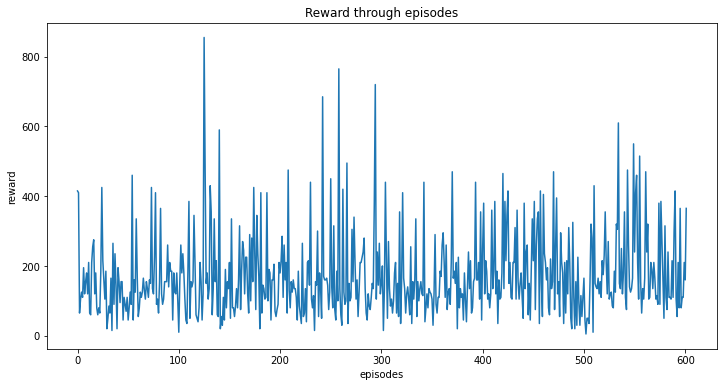

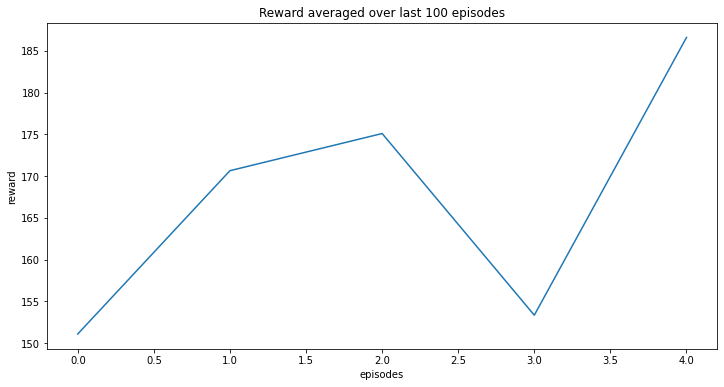

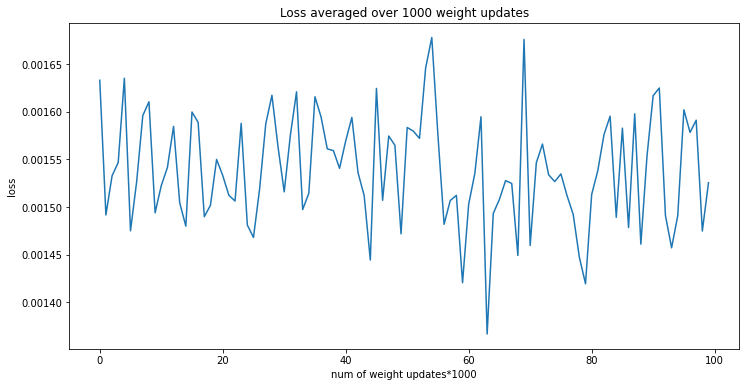

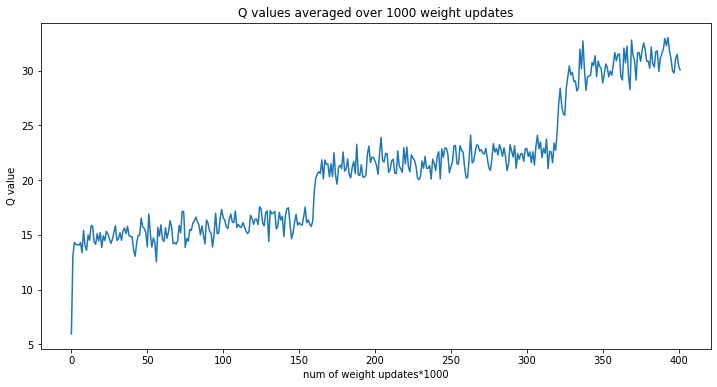

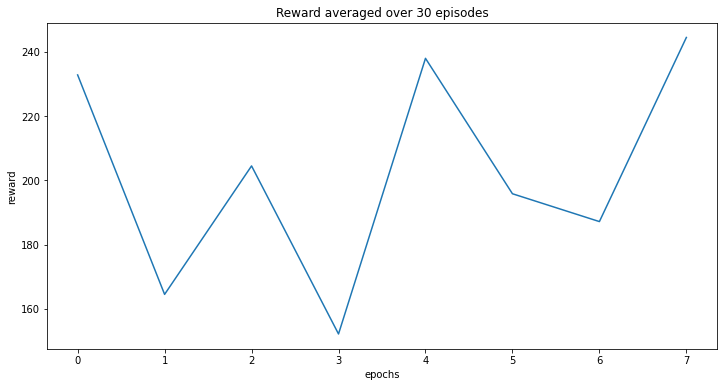

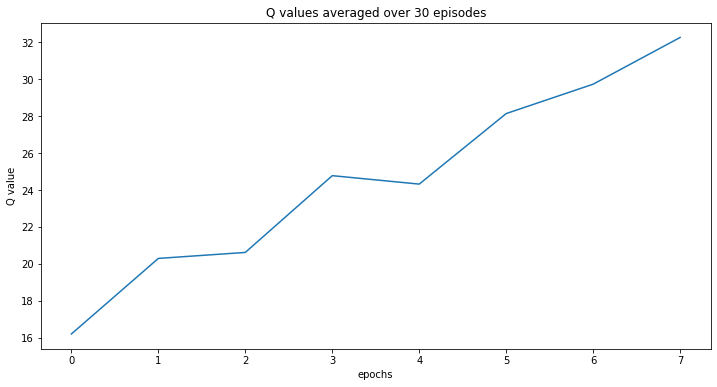

Loss is saved to google_drive/My Drive/Colab Notebooks/loss.txt
Q values are saved to google_drive/My Drive/Colab Notebooks/Qvalues.txt
Rewards are saved to google_drive/My Drive/Colab Notebooks/rewards.txt
Replay buffer is saved to google_drive/My Drive/Colab Notebooks/replayBuffer.txt
Epsilon is saved to google_drive/My Drive/Colab Notebooks/epsilon.txt
Eval rewards are saved to google_drive/My Drive/Colab Notebooks/evalRewards.txt
Eval Q values are saved to google_drive/My Drive/Colab Notebooks/evalQvalues.txt
EPISODE 601
reward: 80.0
Clipped reward: 3.0
epsilon: 0.2736981999860938
buffer size: 300000
EPISODE 602
reward: 260.0
Clipped reward: 13.0
epsilon: 0.27195039998609744
buffer size: 300000
EPISODE 603
reward: 315.0
Clipped reward: 15.0
epsilon: 0.2696769999861022
buffer size: 300000
EPISODE 604
reward: 210.0
Clipped reward: 9.0
epsilon: 0.2681883999861053
buffer size: 300000
EPISODE 605
reward: 290.0
Clipped reward: 16.0
epsilon: 0.26628939998610923
buffer size: 300000
EPISODE

The network is saved to google_drive/My Drive/Colab Notebooks/trained_model/model.h5
Playing the game!
EPSIODE 0
episode reward: 210.0
EPSIODE 1
episode reward: 10.0
EPSIODE 2
episode reward: 80.0
EPSIODE 3
episode reward: 390.0
EPSIODE 4
episode reward: 345.0
EPSIODE 5
episode reward: 140.0
EPSIODE 6
episode reward: 545.0
EPSIODE 7
episode reward: 115.0
EPSIODE 8
episode reward: 120.0
EPSIODE 9
episode reward: 285.0
EPSIODE 10
episode reward: 440.0
EPSIODE 11
episode reward: 220.0
EPSIODE 12
episode reward: 370.0
EPSIODE 13
episode reward: 175.0
EPSIODE 14
episode reward: 240.0
EPSIODE 15
episode reward: 120.0
EPSIODE 16
episode reward: 45.0
EPSIODE 17
episode reward: 150.0
EPSIODE 18
episode reward: 115.0
EPSIODE 19
episode reward: 410.0
EPSIODE 20
episode reward: 150.0
EPSIODE 21
episode reward: 205.0
EPSIODE 22
episode reward: 115.0
EPSIODE 23
episode reward: 65.0
EPSIODE 24
episode reward: 460.0
EPSIODE 25
episode reward: 70.0
EPSIODE 26
episode reward: 180.0
EPSIODE 27
episode re

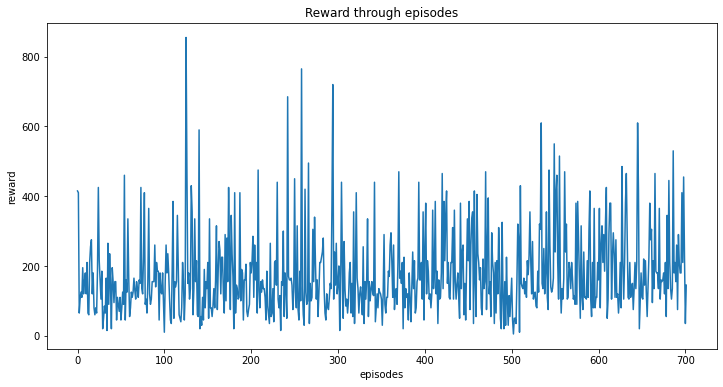

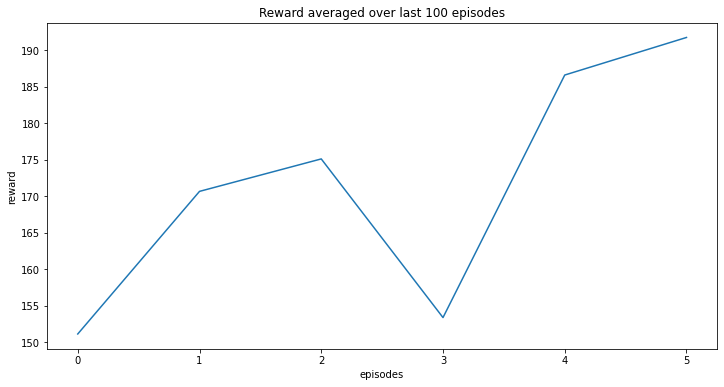

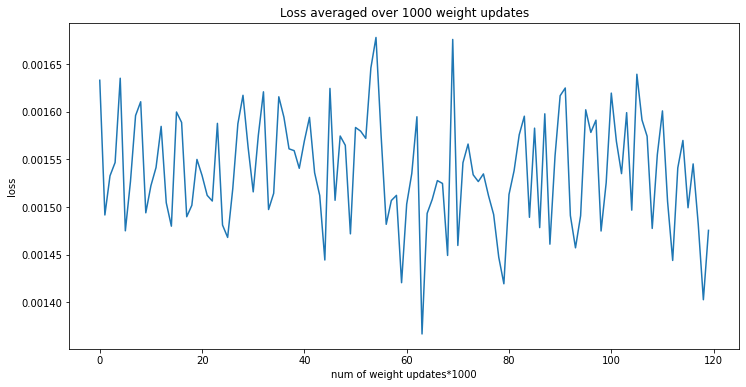

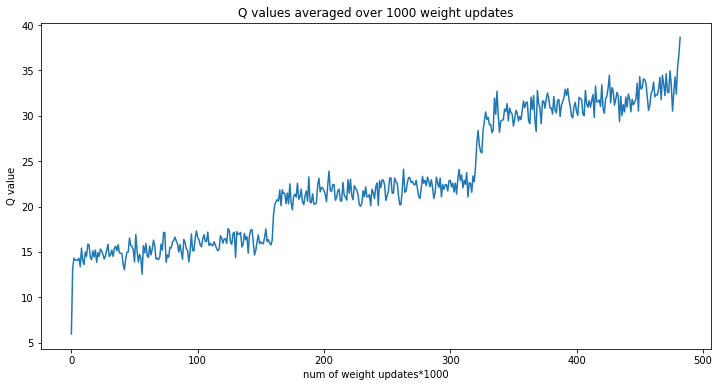

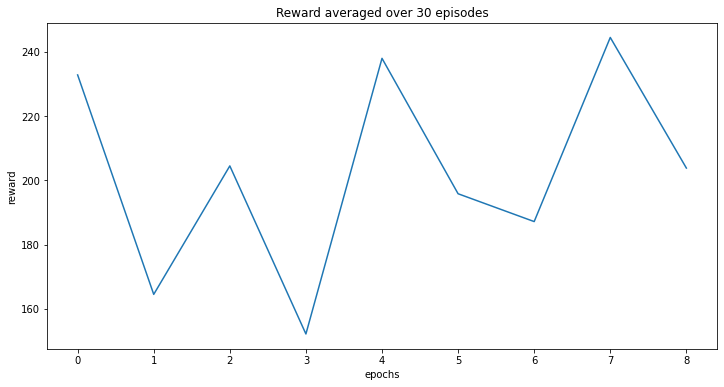

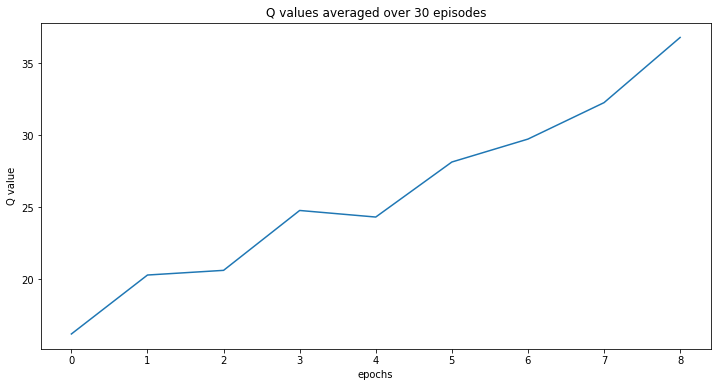

Loss is saved to google_drive/My Drive/Colab Notebooks/loss.txt
Q values are saved to google_drive/My Drive/Colab Notebooks/Qvalues.txt
Rewards are saved to google_drive/My Drive/Colab Notebooks/rewards.txt
Replay buffer is saved to google_drive/My Drive/Colab Notebooks/replayBuffer.txt
Epsilon is saved to google_drive/My Drive/Colab Notebooks/epsilon.txt
Eval rewards are saved to google_drive/My Drive/Colab Notebooks/evalRewards.txt
Eval Q values are saved to google_drive/My Drive/Colab Notebooks/evalQvalues.txt
EPISODE 701
reward: 170.0
Clipped reward: 9.0
epsilon: 0.12765519998639813
buffer size: 300000
EPISODE 702
reward: 80.0
Clipped reward: 3.0
epsilon: 0.1264635999864006
buffer size: 300000
EPISODE 703
reward: 145.0
Clipped reward: 6.0
epsilon: 0.12520359998640324
buffer size: 300000
EPISODE 704
reward: 135.0
Clipped reward: 6.0
epsilon: 0.12399219998640576
buffer size: 300000
EPISODE 705
reward: 120.0
Clipped reward: 5.0
epsilon: 0.1230633999864077
buffer size: 300000
EPISODE 7

The network is saved to google_drive/My Drive/Colab Notebooks/trained_model/model.h5
Playing the game!
EPSIODE 0
episode reward: 135.0
EPSIODE 1
episode reward: 105.0
EPSIODE 2
episode reward: 410.0
EPSIODE 3
episode reward: 210.0
EPSIODE 4
episode reward: 240.0
EPSIODE 5
episode reward: 105.0
EPSIODE 6
episode reward: 110.0
EPSIODE 7
episode reward: 185.0
EPSIODE 8
episode reward: 180.0
EPSIODE 9
episode reward: 105.0
EPSIODE 10
episode reward: 210.0
EPSIODE 11
episode reward: 135.0
EPSIODE 12
episode reward: 180.0
EPSIODE 13
episode reward: 75.0
EPSIODE 14
episode reward: 455.0
EPSIODE 15
episode reward: 210.0
EPSIODE 16
episode reward: 135.0
EPSIODE 17
episode reward: 120.0
EPSIODE 18
episode reward: 110.0
EPSIODE 19
episode reward: 355.0
EPSIODE 20
episode reward: 110.0
EPSIODE 21
episode reward: 135.0
EPSIODE 22
episode reward: 210.0
EPSIODE 23
episode reward: 155.0
EPSIODE 24
episode reward: 180.0
EPSIODE 25
episode reward: 160.0
EPSIODE 26
episode reward: 210.0
EPSIODE 27
episod

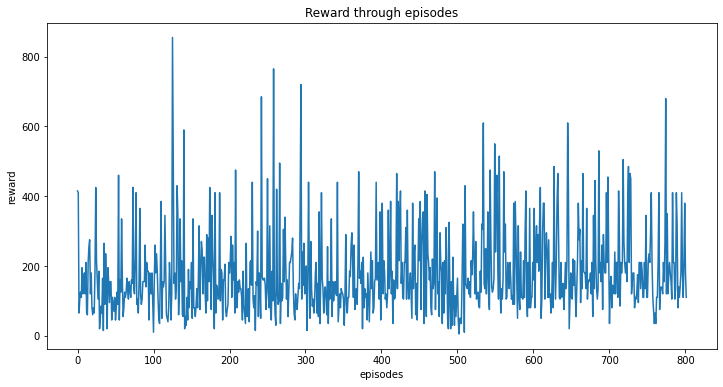

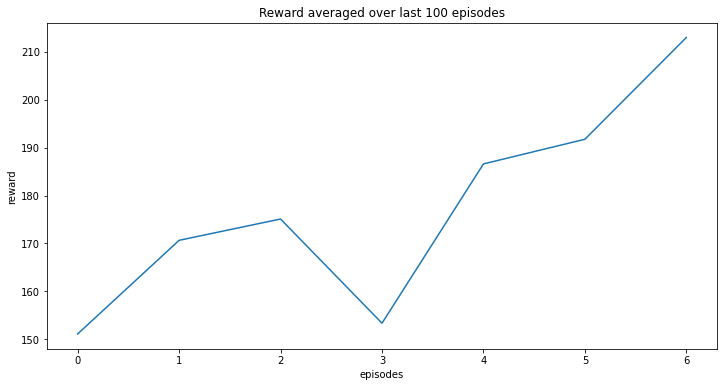

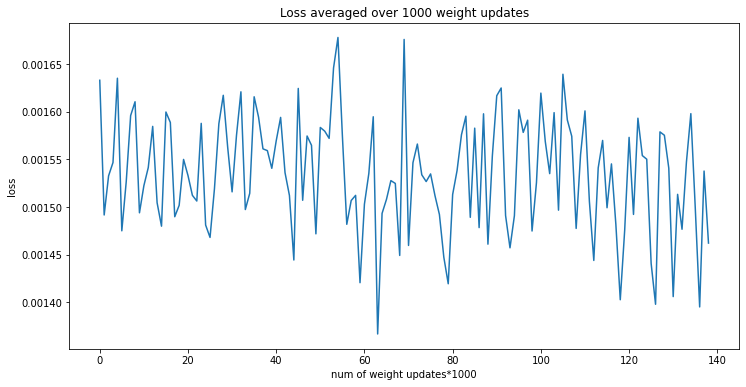

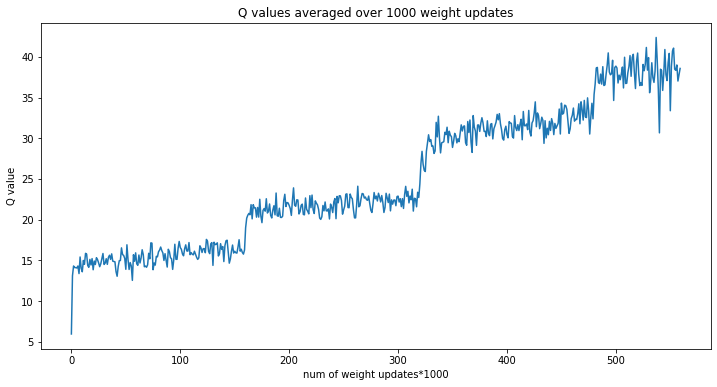

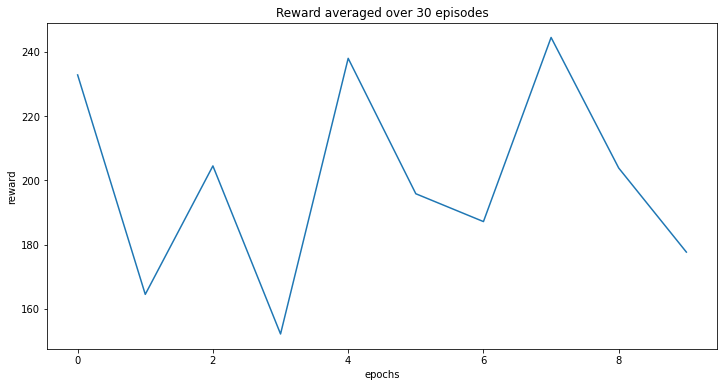

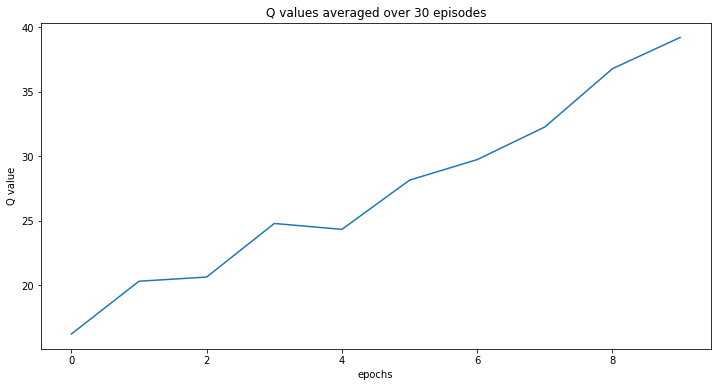

Loss is saved to google_drive/My Drive/Colab Notebooks/loss.txt
Q values are saved to google_drive/My Drive/Colab Notebooks/Qvalues.txt
Rewards are saved to google_drive/My Drive/Colab Notebooks/rewards.txt
Replay buffer is saved to google_drive/My Drive/Colab Notebooks/replayBuffer.txt
Epsilon is saved to google_drive/My Drive/Colab Notebooks/epsilon.txt
Eval rewards are saved to google_drive/My Drive/Colab Notebooks/evalRewards.txt
Eval Q values are saved to google_drive/My Drive/Colab Notebooks/evalQvalues.txt
EPISODE 801
reward: 80.0
Clipped reward: 3.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 802
reward: 270.0
Clipped reward: 13.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 803
reward: 135.0
Clipped reward: 6.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 804
reward: 510.0
Clipped reward: 17.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 805
reward: 210.0
Clipped reward: 9.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISO

The network is saved to google_drive/My Drive/Colab Notebooks/trained_model/model.h5
Playing the game!
EPSIODE 0
episode reward: 210.0
EPSIODE 1
episode reward: 30.0
EPSIODE 2
episode reward: 30.0
EPSIODE 3
episode reward: 180.0
EPSIODE 4
episode reward: 50.0
EPSIODE 5
episode reward: 175.0
EPSIODE 6
episode reward: 80.0
EPSIODE 7
episode reward: 210.0
EPSIODE 8
episode reward: 165.0
EPSIODE 9
episode reward: 210.0
EPSIODE 10
episode reward: 110.0
EPSIODE 11
episode reward: 180.0
EPSIODE 12
episode reward: 240.0
EPSIODE 13
episode reward: 260.0
EPSIODE 14
episode reward: 105.0
EPSIODE 15
episode reward: 410.0
EPSIODE 16
episode reward: 355.0
EPSIODE 17
episode reward: 575.0
EPSIODE 18
episode reward: 110.0
EPSIODE 19
episode reward: 80.0
EPSIODE 20
episode reward: 445.0
EPSIODE 21
episode reward: 210.0
EPSIODE 22
episode reward: 610.0
EPSIODE 23
episode reward: 500.0
EPSIODE 24
episode reward: 155.0
EPSIODE 25
episode reward: 110.0
EPSIODE 26
episode reward: 110.0
EPSIODE 27
episode re

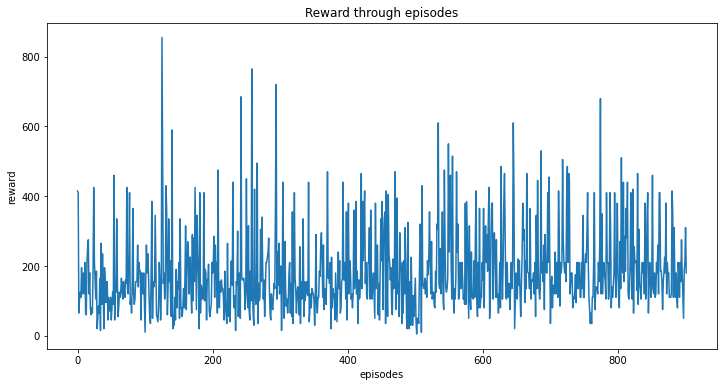

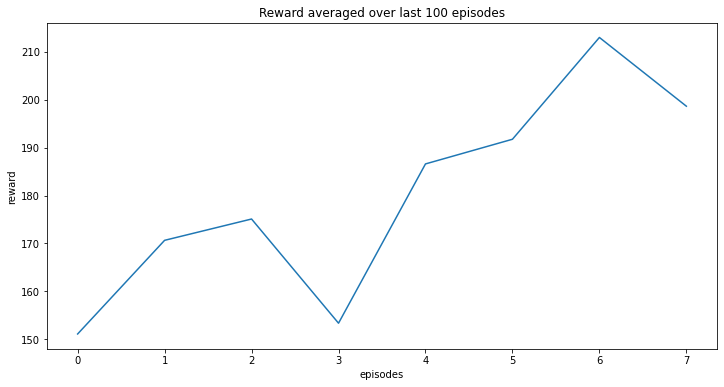

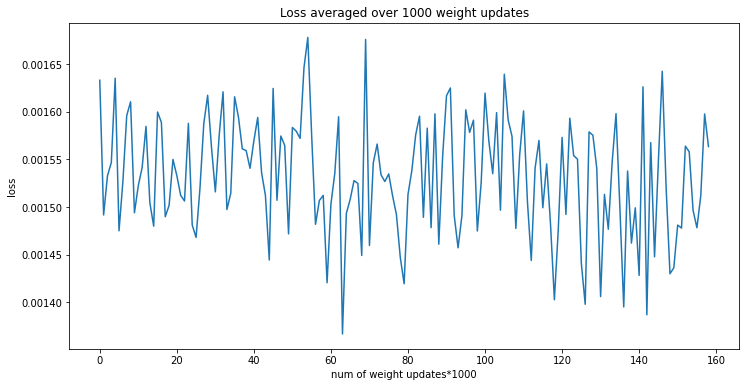

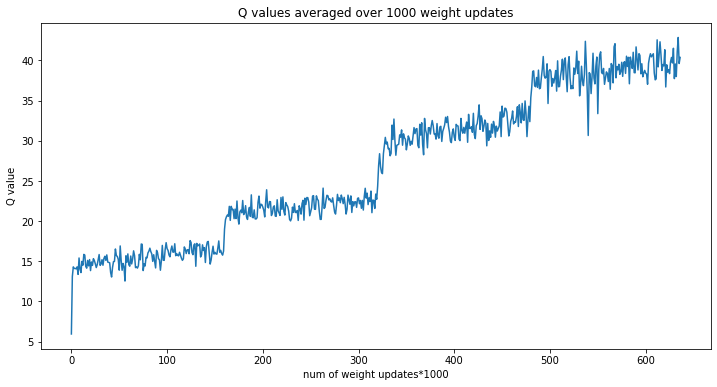

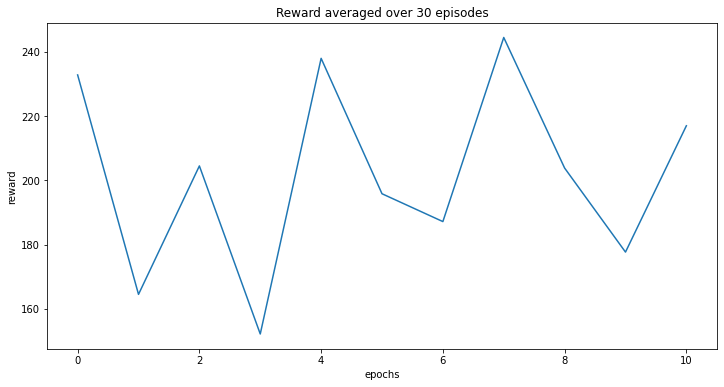

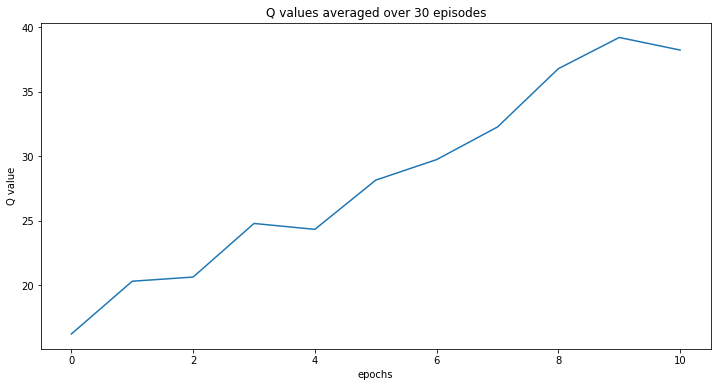

Loss is saved to google_drive/My Drive/Colab Notebooks/loss.txt
Q values are saved to google_drive/My Drive/Colab Notebooks/Qvalues.txt
Rewards are saved to google_drive/My Drive/Colab Notebooks/rewards.txt
Replay buffer is saved to google_drive/My Drive/Colab Notebooks/replayBuffer.txt
Epsilon is saved to google_drive/My Drive/Colab Notebooks/epsilon.txt
Eval rewards are saved to google_drive/My Drive/Colab Notebooks/evalRewards.txt
Eval Q values are saved to google_drive/My Drive/Colab Notebooks/evalQvalues.txt
EPISODE 901
reward: 395.0
Clipped reward: 21.0
epsilon: 0.09999999998645576
buffer size: 300000
Target_network is updated!
Target_network is updated!
Target_network is updated!
Target_network is updated!
EPISODE 902
reward: 75.0
Clipped reward: 2.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 903
reward: 270.0
Clipped reward: 14.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 904
reward: 105.0
Clipped reward: 3.0
epsilon: 0.09999999998645576
buffer size:

The network is saved to google_drive/My Drive/Colab Notebooks/trained_model/model.h5
Playing the game!
EPSIODE 0
episode reward: 260.0
EPSIODE 1
episode reward: 50.0
EPSIODE 2
episode reward: 210.0
EPSIODE 3
episode reward: 355.0
EPSIODE 4
episode reward: 210.0
EPSIODE 5
episode reward: 155.0
EPSIODE 6
episode reward: 180.0
EPSIODE 7
episode reward: 180.0
EPSIODE 8
episode reward: 380.0
EPSIODE 9
episode reward: 110.0
EPSIODE 10
episode reward: 210.0
EPSIODE 11
episode reward: 180.0
EPSIODE 12
episode reward: 290.0
EPSIODE 13
episode reward: 185.0
EPSIODE 14
episode reward: 260.0
EPSIODE 15
episode reward: 210.0
EPSIODE 16
episode reward: 210.0
EPSIODE 17
episode reward: 110.0
EPSIODE 18
episode reward: 410.0
EPSIODE 19
episode reward: 180.0
EPSIODE 20
episode reward: 55.0
EPSIODE 21
episode reward: 295.0
EPSIODE 22
episode reward: 240.0
EPSIODE 23
episode reward: 110.0
EPSIODE 24
episode reward: 80.0
EPSIODE 25
episode reward: 50.0
EPSIODE 26
episode reward: 260.0
EPSIODE 27
episode r

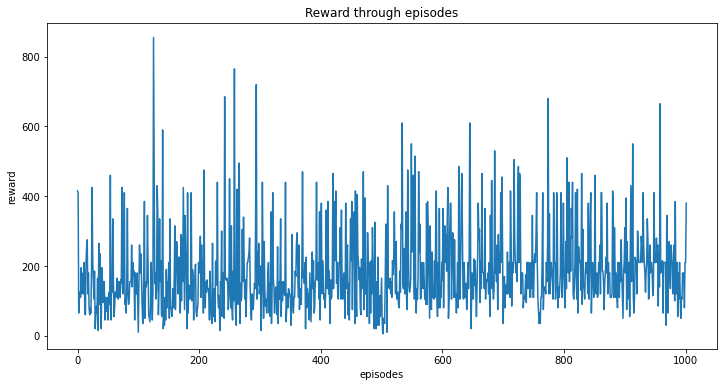

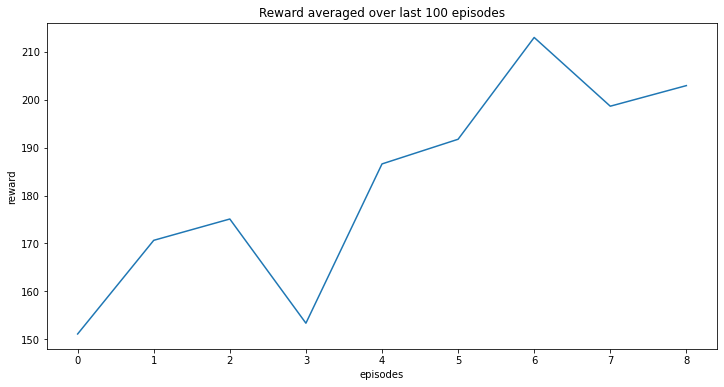

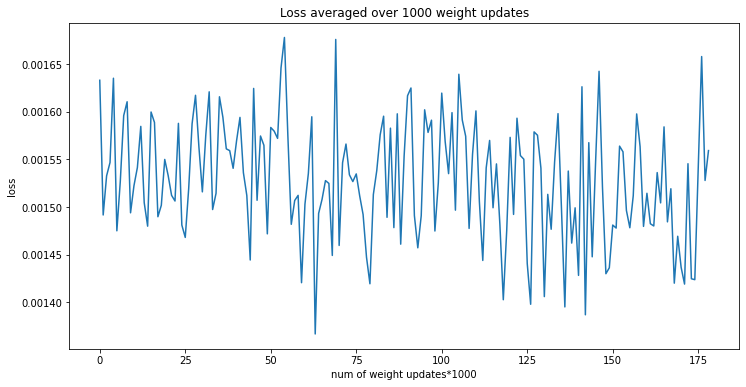

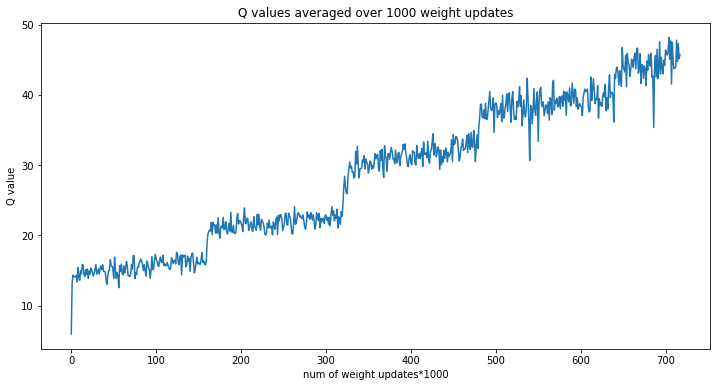

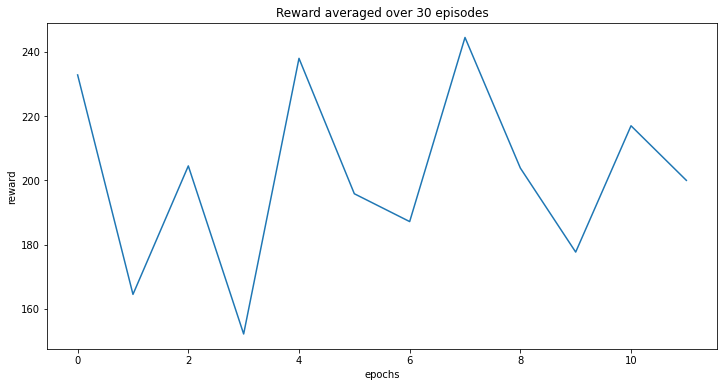

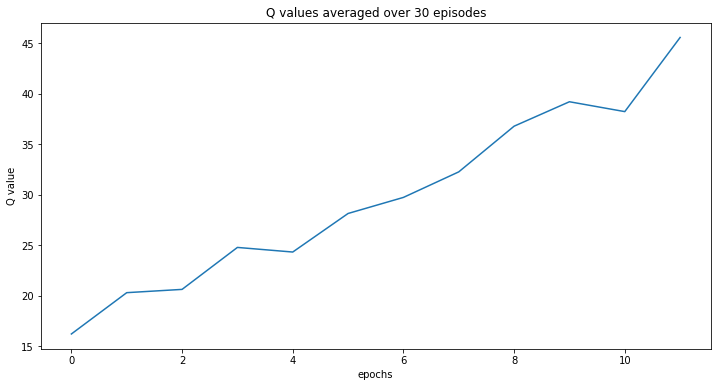

Loss is saved to google_drive/My Drive/Colab Notebooks/loss.txt
Q values are saved to google_drive/My Drive/Colab Notebooks/Qvalues.txt
Rewards are saved to google_drive/My Drive/Colab Notebooks/rewards.txt
Replay buffer is saved to google_drive/My Drive/Colab Notebooks/replayBuffer.txt
Epsilon is saved to google_drive/My Drive/Colab Notebooks/epsilon.txt
Eval rewards are saved to google_drive/My Drive/Colab Notebooks/evalRewards.txt
Eval Q values are saved to google_drive/My Drive/Colab Notebooks/evalQvalues.txt
EPISODE 1001
reward: 180.0
Clipped reward: 8.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 1002
reward: 180.0
Clipped reward: 8.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 1003
reward: 155.0
Clipped reward: 7.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 1004
reward: 75.0
Clipped reward: 2.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 1005
reward: 55.0
Clipped reward: 2.0
epsilon: 0.09999999998645576
buffer size: 300000
EPI

The network is saved to google_drive/My Drive/Colab Notebooks/trained_model/model.h5
Playing the game!
EPSIODE 0
episode reward: 440.0
EPSIODE 1
episode reward: 35.0
EPSIODE 2
episode reward: 210.0
EPSIODE 3
episode reward: 250.0
EPSIODE 4
episode reward: 270.0
EPSIODE 5
episode reward: 215.0
EPSIODE 6
episode reward: 70.0
EPSIODE 7
episode reward: 125.0
EPSIODE 8
episode reward: 30.0
EPSIODE 9
episode reward: 210.0
EPSIODE 10
episode reward: 105.0
EPSIODE 11
episode reward: 155.0
EPSIODE 12
episode reward: 45.0
EPSIODE 13
episode reward: 210.0
EPSIODE 14
episode reward: 210.0
EPSIODE 15
episode reward: 80.0
EPSIODE 16
episode reward: 120.0
EPSIODE 17
episode reward: 380.0
EPSIODE 18
episode reward: 290.0
EPSIODE 19
episode reward: 410.0
EPSIODE 20
episode reward: 55.0
EPSIODE 21
episode reward: 460.0
EPSIODE 22
episode reward: 215.0
EPSIODE 23
episode reward: 125.0
EPSIODE 24
episode reward: 180.0
EPSIODE 25
episode reward: 210.0
EPSIODE 26
episode reward: 155.0
EPSIODE 27
episode rew

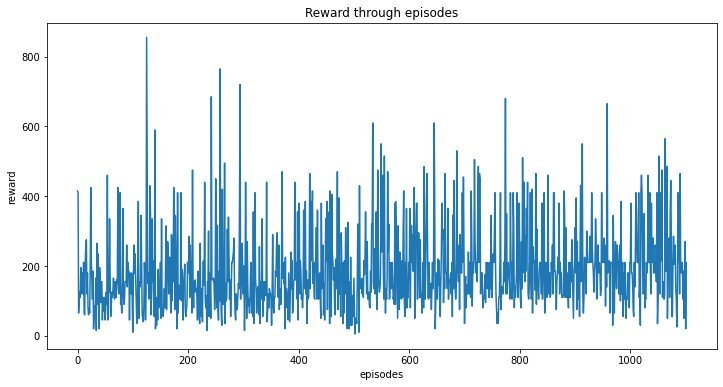

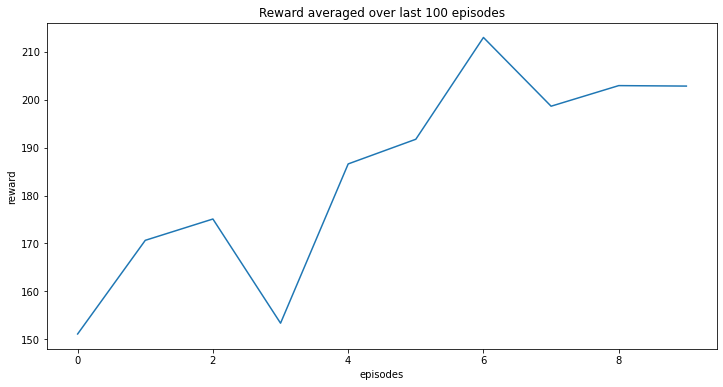

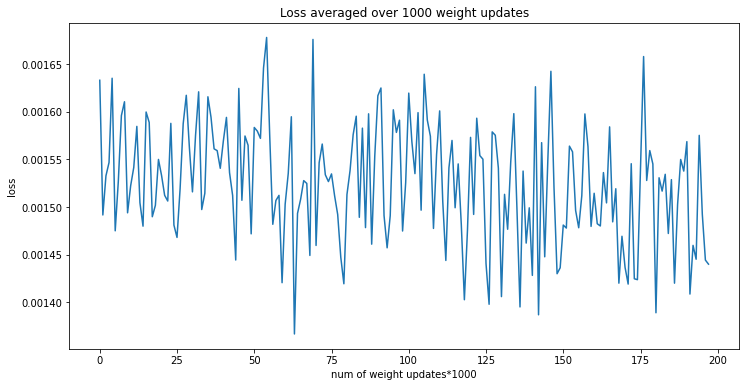

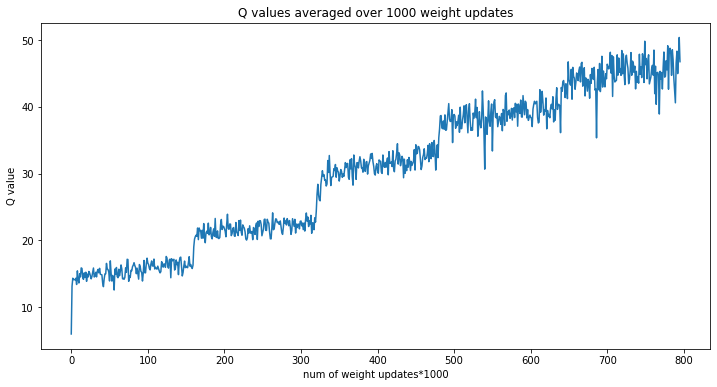

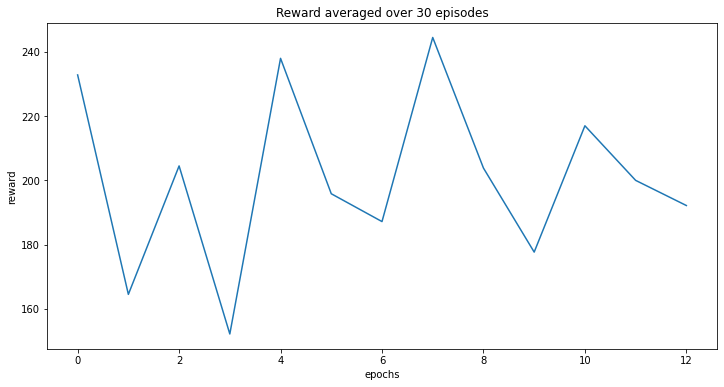

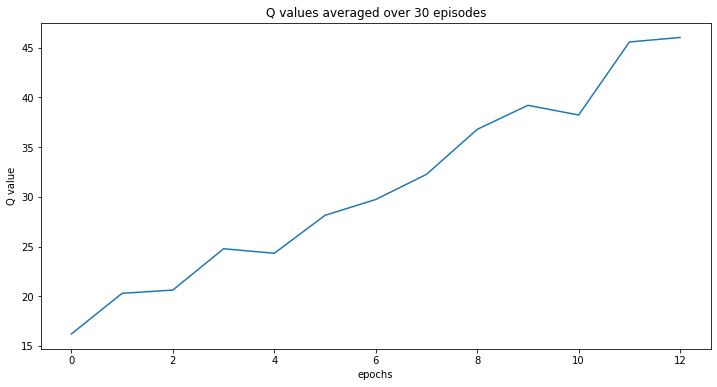

Loss is saved to google_drive/My Drive/Colab Notebooks/loss.txt
Q values are saved to google_drive/My Drive/Colab Notebooks/Qvalues.txt
Rewards are saved to google_drive/My Drive/Colab Notebooks/rewards.txt
Replay buffer is saved to google_drive/My Drive/Colab Notebooks/replayBuffer.txt
Epsilon is saved to google_drive/My Drive/Colab Notebooks/epsilon.txt
Eval rewards are saved to google_drive/My Drive/Colab Notebooks/evalRewards.txt
Eval Q values are saved to google_drive/My Drive/Colab Notebooks/evalQvalues.txt
EPISODE 1101
reward: 295.0
Clipped reward: 17.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 1102
reward: 75.0
Clipped reward: 2.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 1103
reward: 210.0
Clipped reward: 9.0
epsilon: 0.09999999998645576
buffer size: 300000
EPISODE 1104
reward: 80.0
Clipped reward: 3.0
epsilon: 0.09999999998645576
buffer size: 300000
Target_network is updated!
Target_network is updated!
Target_network is updated!
Target_network is

In [0]:
import gym
import numpy as np
import sys

space_invaders = Environment('SpaceInvaders-v0',ACTIONS)
space_invaders.wrap_env()
Q = DQN(RESOLUTION, NUM_OF_FRAMES, len(ACTIONS), OPTIMIZER)
Q.load_network(file_path)

agent = Agent()
agent.train(Q, space_invaders, file_path, continue_training=True, EPISODE=500)

# **Play the game**

In [17]:
epsilon = 0
episodes = 3
space_invaders = Environment('SpaceInvaders-v0',ACTIONS)
space_invaders.wrap_env()
Q = DQN(RESOLUTION, NUM_OF_FRAMES, len(ACTIONS), OPTIMIZER)

agent = Agent()
e_rewards, q_values, mean_reward, mean_q_value = agent.play_game(epsilon, Q, space_invaders, episodes, load_pretrained=True, render=True)
space_invaders.show_video()
print("Average episode reward is {}".format(mean_reward))

Playing the game!
The network is loaded from google_drive/My Drive/Colab Notebooks/trained_model/model.h5
EPSIODE 0
episode reward: 275.0
EPSIODE 1
episode reward: 265.0
EPSIODE 2
episode reward: 290.0
video/openaigym.video.3.6673.video000001.mp4


Average episode reward is 276.6666666666667


# DEBUG


In [0]:
# CHECK the packState and unpackState (what goes in and out of replay buffer)

space_invaders = Environment('SpaceInvaders-v0',ACTIONS)
space_invaders.wrap_env()
d = True
for i in range(1000):
    if d:
       frames,_,_ = space_invaders.resetEnv(NUM_OF_FRAMES)
       frames_buffer=frames
    o, r,d, info = space_invaders.step(np.random.randint(0,6))
    if i == 500:
        state = stackFrames(frames_buffer)
    frame = preprocessFrame(o,RESOLUTION)
    frames_buffer.append(frame)
    frames_buffer.pop(0)
packed_state = packState(state)
unpacked_state = unpackState(packed_state,RESOLUTION, NUM_OF_FRAMES)
for i in range(NUM_OF_FRAMES):
    plt.figure()
    plt.imshow(state[:,:,i])
    plt.figure()
    plt.imshow(unpacked_state[:,:,i])

In [0]:
# Check target_network and network 
